In [228]:
import numpy as np
from sklearn.datasets import load_digits , make_moons
import matplotlib.pyplot as plt

In [229]:
data = load_digits()
X = data.data
y = data.target

## modules for making the multi layer preceptron.
### 1. Data Handling & Preprocessing
- Train/test split
- Standardization
- One-hot encoding
- Batch generator
### 2.  Network Initialization
- Define MLP class
- Weight & bias initialization (Xavier/He)
- Store architecture (layers, activations)
### 3. Forward Propagation
- Dense layer linear transformation
- Activation functions (ReLU, Sigmoid, Tanh, Softmax)
### 4. Loss Functions
- Categorical Cross-Entropy (for classification)
- Mean Squared Error (for regression)
### 5. Backward Propagation
- Gradients for each activation function
- Gradients for Dense layers (weights & biases)
### 6. Update function or Optimizer
- Vanilla SGD- 
### 7. Fit function
- Mini-batch iteration
- Forward pass → Loss → Backward pass → Update
- Track loss & accuracy
### 8. Predict function
- Accuracy computation
- Predictions (argmax for classification)
### 9. Testing & Experimentation
- Run on a small dataset (e.g., Iris)


### MODULE 1: Data Handling & Preprocessing

In [230]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y

def standardize(train_X, test_X):
    # Standardizes features to mean=0, std=1 using training set statistics.
    mean = np.mean(train_X, axis = 0)
    std = np.std(train_X, axis = 0) + 1e-8
    return (train_X - mean) / std, (test_X - mean) / std


def one_hot_encoding(y, num_classes = None):
    if num_classes is None:
        num_classes = len(np.unique(y))
    encoded = np.zeros((len(y), num_classes))
    encoded[np.arange(len(y)), y] = 1
    return encoded

def batch_generator(X, y, batch_size, shuffle = True):
    '''
    Yields mini-batches for training.
    '''
    n_samples = len(y)
    idx = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(idx)
    for start_idx in range(0 , n_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_idx = idx[start_idx: end_idx]
        yield X[batch_idx] , y[batch_idx]
        


In [231]:
class MLP:
    ''' 
        --------------------------------
        MODULE 2: NETWORK INITIALIZATION
        --------------------------------
    '''
    
    
    def __init__(self, layers, n_iter = 1 ,learning_rate = 0.01, batch_size = 5,seed = None):
         
        '''
        layers: list defining numbers of neurons per layer.
            Example: [input_dim, hidden1, hidden2, output_dim]
            
        seed: for reproducibility
        '''
        if seed:
            np.random.seed(seed)

        self.layers = layers
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        
        self.w_layers = len(layers) - 1    # no. of weight layers
        self.params = {}                   # stores weights and biases
        self.loss_history = []
        
        # Initialize weights & biases
        for i in range(1, len(layers)):
            n_in, n_out = layers[i-1], layers[i]

            # Xavier initialization
            limit = np.sqrt(6 / (n_in + n_out))
            self.params[f'W{i}'] = np.random.uniform(low = -limit, high = limit, size = (n_in, n_out))
            self.params[f'B{i}'] = np.zeros(shape = (1, n_out))
            
    ''' 
        -----------------------------
        MODULE 3: Forward Propagation
        -----------------------------
    '''
    # ---Activation Functions----

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
        return expZ / np.sum(expZ , axis = 1, keepdims = True)

    # ---Forward propogation----
    
    def forward(self, X):
        '''
            Forward pass through the network.
    
            X: input data (m x n_input)
            Returns: output predictions

            forward propagation is just linear step (Z) + non-linear activation (A) repeated layer by layer.
        '''
        cache = {'A0' : X}
        for i in range(1, self.w_layers + 1):
            W = self.params[f'W{i}']
            B = self.params[f'B{i}']

            
            # linear step
            # for layer l: 
            # Z[l] = A[l-1] . W[l] + B[l]
            
            Z = np.dot(cache[f'A{i-1}'], W) + B
            
            # non_linear activation
            # A[l] = fn[l](Z[l])
            
            if i == self.w_layers:
                A = self.softmax(Z)   # for output layer
            else:
                A = self.relu(Z)     # for hidden layers

            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A
        
        return cache
        

    ''' 
        -----------------------
        MODULE 4: Loss Function
        -----------------------
    '''
    def cross_entropy_loss(self , cache , y):
        y_pred = cache[f'A{self.w_layers}']
        m = y.shape[0]
        
        loss = -np.sum(y * np.log(y_pred + 1e-9)) / m
        return loss
        
    ''' 
        ------------------------------
        MODULE 5: Backward Propagation
        ------------------------------
    '''
     # ---Activation Derivatives----

    def relu_D(self, Z):
         return (Z > 0).astype(float)
        
    # softmax derivative is also suppose to be here, but it was easier to put it directly inside the back propagation function. 

    # ---Backward propogation----
    
    def back(self, cache, y):
        m = len(y)
        L = self.w_layers
        AL = cache[f'A{L}']

        grad = {}

        # ----- Output layer -----
        
        dZ = AL - y         #(Softmax + Cross_Entropy): dZL = AL - Y  (softmax derivative)

        A_prev = cache[f'A{L - 1}']
        W = self.params[f'W{L}']

        grad[f'dW{L}'] = np.dot(A_prev.T , dZ) / m
        grad[f'dB{L}'] = np.sum(dZ, axis = 0 , keepdims = True) / m

        # ----- hidden layers -----
        
        for l in reversed(range(1, L)):
            # the first dZ is taken from the output layer, because it is running in reverse.
            dA = np.dot(dZ, self.params[f'W{l+1}'].T)
            dZ = dA * self.relu_D(cache[f'Z{l}'])

            grad[f'dW{l}'] = np.dot(cache[f'A{l-1}'].T , dZ) / m
            grad[f'dB{l}'] = np.sum(dZ, axis = 0, keepdims = True) / m
        
        return grad
        
    ''' 
        -----------------------------------------------------------
        MODULE 6: Parameter Updates (Gradient Descent) OR Optimizer
        -----------------------------------------------------------
    '''

    def update_params(self, grad):
        L = self.w_layers

        for l in range(1, L+1):
            self.params[f'W{l}'] -= self.learning_rate * grad[f'dW{l}']
            self.params[f'B{l}'] -= self.learning_rate * grad[f'dB{l}']

    ''' 
        --------------------------------------
        MODULE 7: fit function (Training loop)
        --------------------------------------
    '''
    def fit(self, X, y):

        for i in range(self.n_iter):
            epoch_loss = 0
            for X_batch , y_batch in batch_generator(X, y , batch_size = self.batch_size):
                # forward
                cache = self.forward(X_batch)
                
                # loss
                loss = self.cross_entropy_loss(cache, y_batch)
                epoch_loss += loss
                # backward
                grads = self.back(cache, y_batch)

                # update
                self.update_params(grads)

                
            avg_loss = epoch_loss / (len(X) // self.batch_size)
            self.loss_history.append(avg_loss)

    ''' 
        --------------------------
        MODULE 8: Predict function
        --------------------------
    '''

    def predict(self, X):
        cache = self.forward(X)
        A_out = cache[f'A{self.w_layers}']
        return np.argmax(A_out , axis = 1)
        
        

### MODULE 9 : Model Testing

In [232]:
train_X, train_y, test_X, test_y = train_test_split(X, y, ratio = 0.6 , shuffle = True, seed = 1)
train_X, test_X = standardize(train_X, test_X)
train_y  = one_hot_encoding(train_y)

mlp = MLP(layers=[X.shape[1], 200 , 200 ,len(np.unique(y))],n_iter = 100 , learning_rate = 0.05, batch_size = 50 ,seed=4)
mlp.fit(train_X, train_y)
y_pred = mlp.predict(test_X)
accuracy = np.mean(y_pred == test_y)
print('Accuracy: ' , accuracy)

Accuracy:  0.9791376912378303


## Loss Curve

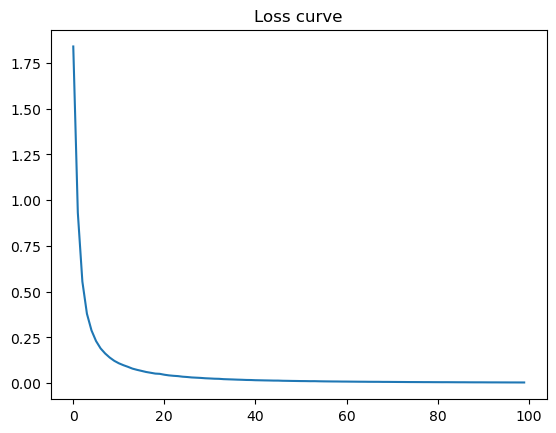

In [233]:
plt.plot(mlp.loss_history)
plt.title('Loss curve')
plt.show()

## Confusion Matrix

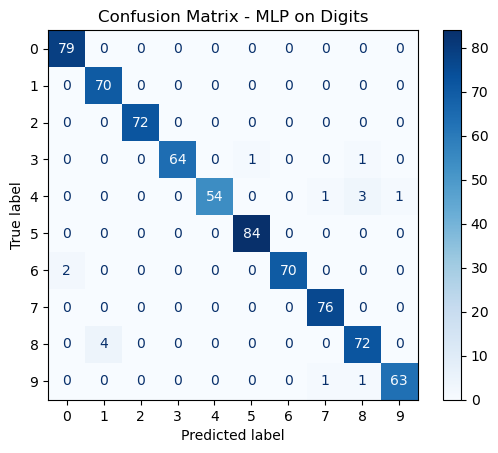

In [234]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - MLP on Digits")
plt.show()